## RGC-01

An introduction to retinal ganglion cell processing. For a moving bar
stimulus, an experimental mosaic is loaded, and its average parameters
are calculated and shifted to a user-input eccentricity.

Generate a moving bar stimulus and measure the response of a simulated
retinal patch from photoreceptors to retinal ganglion cells.

The tutorial begins with the user choosing several parameters, including
the eccentricity and field of view of the simulated retinal patch. The
isetbio pathway generates a display, a scene, an optical image, a cone
absorptions/sensor mosaic, an outer segement mosaic, a bipolar mosaic and
a retinal ganglion cell mosaic. 

The moving bar stimulus is generated frame by frame. For each frame, the
scene is created using a grayscale image and the loaded display
parameters for a particular monitor. The optical image is computed by
simulating the cornea and lens. The cone absorptions are computed for a
generated cone mosaic at the specified eccentricity using the optical
image. This process, from the raw grayscale stimulus to the cone
absorptions, is done frame by frame in a loop.

A biophysical model of the cone outer segment from the Rieke Lab is
employed to generate the cone photocurrent. This signal is passed on to a
bipolar cell mosaic, which implements spatial pooling and temporal
filtering.

An experimental dataset that represents an RGC mosaic of a peripheral
patch is loaded from Chichilnisky Lab data, and a mosaic of the average
RGC is created that completely tiles the space. The RGC sizes are
dependent on the eccentricity input by the user.

The mosaic of cones, bipolar cells and RGCs may be viewed, and a
movie of the PSTHs placed spatially on the mosaic can also be constructed.

See also:
  EJLFigureReproduction/t_rgcNaturalScenesFig2.m
  t_rgcCascade.m
  t_rgcPeriphery.m

6/2016 JRG (c) isetbio team


In [24]:
%% Initialize parameters for RGC mosaic

% Specify retinal patch eccentricity and field of view;
ecc = 0.03;    % in mm
fov = 3*0.25;  % in degrees of visual angle

% Choose the experimental dataset, cell type, and stimulus
experimentI   = 1;       % Choose 1. RPE 2016-02-17-1, loads parameters and spikes
cellTypeI     = 7;       % Choose 1. OnPar, 2. OffPar, 3. OnMidg, 4. OffMidg, 5. SBC
stimulusTestI = 1;       % Choose 1. Moving bar

In [25]:
%% Moving bar stimulus
% In order to generate an isetbio stimulus, the user must choose a stimulus
% and specify a set of parameters. For this tutorial, we work with a
% stimulus that is a movie of a white bar on a background sweeping from
% left to right.

% Scene parameters
params.barWidth = 2;
params.row = 64; params.col = 64;

% Luminance
params.meanLuminance = 200;

% Temporal parameters
downSampleFactor = 20;
params.timeInterval = .0004;%(1/125)/upSampleFactor;%0.001; % sec
params.expTime      = .0004;%(1/125)/upSampleFactor;%0.001; % sec
params.nSteps = 5*150;     % Number of stimulus frames

% Retina patch parameters
params.fov = fov;       % set at top
params.radius = ecc;    % set at top
params.theta = 0;       % 3 oclock on the retina
params.side = 'left';   % eye side, used for temporal equiv ecc


In [26]:
%% Compute an empty scene as a placeholder for the bar image

% Create display
display = displayCreate;

% Set up default scene
scene = sceneCreate();
scene = sceneSet(scene, 'h fov', fov);

In [27]:
%% Initialize the optics and the sensor

% Generate the default optical image
oi  = oiCreate('wvf human');

if params.radius == 0
    % Assume foveal cone density
    absorptions = sensorCreate('human');

else
    % Generate cone mosaic with density according to eccentricitiy
    coneP = coneCreate; % The default cone properties
    retinalRadiusDegrees = params.radius;
    retinalPolarDegrees  = params.theta;
    whichEye             = params.side;
    retinalPos = [retinalRadiusDegrees retinalPolarDegrees]; 
    absorptions = sensorCreate('human', [coneP], [retinalPos], [whichEye]);
end

% Get the cone mosaic and plot it
cone_mosaic = sensorGet(absorptions,'cone type');

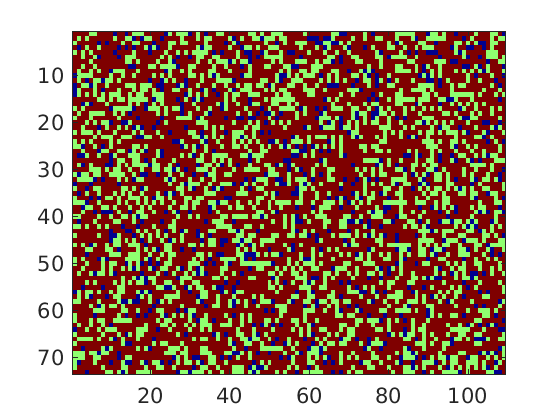

In [28]:
%% Initialize the optics and the sensor

% Generate the default optical image
oi  = oiCreate('wvf human');

if params.radius == 0
    % Assume foveal cone density
    absorptions = sensorCreate('human');

else
    % Generate cone mosaic with density according to eccentricitiy
    coneP = coneCreate; % The default cone properties
    retinalRadiusDegrees = params.radius;
    retinalPolarDegrees  = params.theta;
    whichEye             = params.side;
    retinalPos = [retinalRadiusDegrees retinalPolarDegrees]; 
    absorptions = sensorCreate('human', [coneP], [retinalPos], [whichEye]);
end

% Scale the size of cone mosaic approrpiately
absorptions = sensorSetSizeToFOV(absorptions, params.fov, scene, oi);

% Set aspect ratio
% At this point, we have the right cone density and the right number in
% cols, now we just need to set the rows to have the same aspect ratio as
% the input movie.
sceneSize = sceneGet(scene,'size');
sensorSize = sensorGet(absorptions,'size');
aspectRatioMovie = sceneSize(1)/sceneSize(2);
absorptions = sensorSet(absorptions,'size',[aspectRatioMovie*sensorSize(2) sensorSize(2)]);

absorptions = sensorSet(absorptions, 'exp time', params.expTime); 
absorptions = sensorSet(absorptions, 'time interval', params.timeInterval);

% Get the cone mosaic and plot it
cone_mosaic = sensorGet(absorptions,'cone type');
vcNewGraphWin; imagesc(4-cone_mosaic); colormap jet;

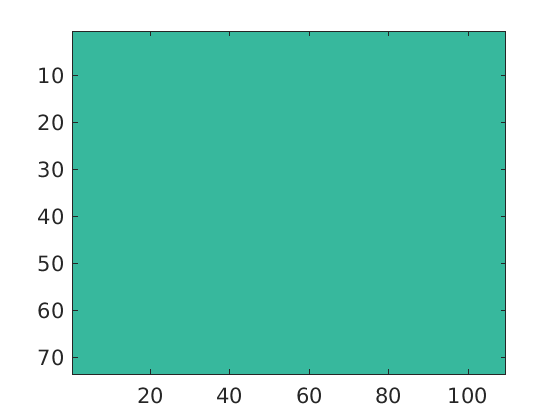

Computing cone isomerizations:


In [33]:
%% Compute a dynamic set of cone absorptions for moving bar

% Status of cone absorptions computation
fprintf('Computing cone isomerizations:    \n');

% The number of steps must be smaller than the width of the scene for the
% moving bar stimulus.
nSteps = 1;%params.nSteps;
if isempty(nSteps), 
    nSteps = sceneGet(scene,'cols') - params.barWidth; 
end
downSampleFactorStep = 4;%downSampleFactor/2;
nSteps = min(downSampleFactorStep*(sceneGet(scene,'cols') - params.barWidth), nSteps);

% Loop through frames to build the oi and absorptions over time
for t = 1 : nSteps
        
    % Build bar image with grayscale array
    barMovie = ones([sceneGet(scene, 'size'), 3])*0.001;  % Gray background
    barMovie(:,ceil(t/downSampleFactorStep):(ceil(t/downSampleFactorStep)+params.barWidth-1),:) = 1;            % White bar at appropriate position

    % Generate scene object from stimulus RGB matrix and display object
    scene = sceneFromFile(barMovie, 'rgb', params.meanLuminance, display);

    % Make sure FOV is correct
    scene = sceneSet(scene, 'h fov', fov);
    % On first step, initialize the sceneRGB matrix
    if t ==1
        sceneRGB = zeros([sceneGet(scene, 'size'), nSteps, 3]);
    end
    
    % Get scene RGB data    
    sceneRGB(:,:,t,:) = sceneGet(scene,'rgb');
    
    % Compute optical image
    oi = oiCompute(oi, scene);    
    
    absorptions = sensorCompute(absorptions, oi);
    
    % On first step, initialize the sensor volts matrix
    if t == 1
        volts = zeros([sensorGet(absorptions, 'size') params.nSteps]);
    end
    
    % Store volts over time so they can be set in the sensor
    volts(:,:,t) = sensorGet(absorptions, 'volts');
        
end

% Set the stimuls into the sensor object
absorptions = sensorSet(absorptions, 'volts', volts);

% Instead of computing, just load precomputed from RDT

rdt = RdtClient('isetbio');
rdt.crp('resources/data/rgc/apricot');
data = rdt.readArtifact('absorptionsBar750fr', 'type', 'mat');
absorptions = data.absorptions;

sensor = absorptions;

figure; imagesc(absorptions.data.volts(:,:,50))

In [11]:
%% Outer segment calculation - biophysical model
% The next step is to get the outer segment current. The biophysical outer
% segment model is employed here.

% % Initialize
osB = osCreate('biophys');

% Set size of retinal patch based on absorptions sensor object
patchSize = sensorGet(sensor,'width','m');
osB = osSet(osB, 'patch size', patchSize);

% Set time step of simulation equal to absorptions sensor object
timeStep = sensorGet(sensor,'time interval','sec');
osB = osSet(osB, 'time step', timeStep);

% Set mean current of outer segment as boundary condition
sensorVolts = sensorGet(sensor,'volts');
paramsOS.bgVolts = 10*mean(sensorVolts(:));
paramsOS.ecc = ecc; % mm
clear sensorVolts

% Compute the outer segment response to the absorptions with the linear
% model.
osB = osCompute(osB,sensor,paramsOS);

osCurrentSize = osGet(osB,'size');
osCurrentNew = zeros([osCurrentSize(1) osCurrentSize(2) ceil(osCurrentSize(3)/downSampleFactor)]);
for fr = 1:osCurrentSize(3)/downSampleFactor
    osCurrentNew(:,:,fr) = osB.coneCurrentSignal(:,:,downSampleFactor*(fr-1)+downSampleFactor);
end

osCurrentNew(:,:,end) = osCurrentNew(:,:,end-1);

osBDS = osB;
osBDS = osSet(osBDS,'coneCurrentSignal', osCurrentNew);
osBDS = osSet(osBDS,'timeStep',0.008);

[Warning: The input is a sensor, should update to use coneMosaic.] 
[> In osBioPhys/osCompute (line 31)
  In pymat_eval (line 31)
  In matlabserver (line 24)]


In [12]:
%% Find bipolar responses
% Build the bipolar mosaic and compute the response

clear bp

% Sets linear, on half-wave rectification, or on and off half-wave rect
bpParams.rectifyType = 1;

% Select the correct type of bipolar cell based on the user-specified RGC mosaic.
switch cellTypeI
    case {1,6}
        bpParams.cellType = 'onDiffuse'; 
    case {2,7}
        bpParams.cellType = 'offDiffuse';
    case {3,8}
        bpParams.cellType = 'onMidget';
    case {4,9}
        bpParams.cellType = 'offMidget';
    case {5,10}
        bpParams.cellType = 'onDiffuseSBC';
        % Sets linear, on half-wave rectification, or on and off half-wave rect
        bpParams.rectifyType = 3;
end

% Sets filter as theoretical, mean physiology, or individual phys:
bpParams.filterType = 1; 


% bpParams.rectifyType = 3;

% Make sure bipolar cells have the right eccentricity
bpParams.ecc = ecc;

% Get cone mosaic
cone_mosaic = sensorGet(absorptions,'cone type');
bpParams.coneMosaic = cone_mosaic;

% Initialize the bipolar object
bp = bipolar(osB, bpParams);

% Compute the bipolar mosaic response
bp = bipolarCompute(bp, osB);


In [34]:
%% Set RGC mosaic parameters

% Switch on the conditions indices
% Experimental dataset
switch experimentI
    case 1; experimentID = 'RPE_201602171';
    otherwise; error('Data not yet available');
end
% The other experimental data will be added to the RDT in the future.

% Stimulus: white noise or natural scene movie with eye movements
switch stimulusTestI
    case 1; stimulusTest = 'bar';
end

cellType = 'Off Parasol Apricot';

In [35]:
%% Set other RGC mosaic parameters

clear params innerRetinaSU
params.name = 'macaque phys';
params.eyeSide = 'left'; 
params.eyeRadius = ecc; 
params.fov = fov;
params.eyeAngle = 0; ntrials = 0;

% Determined at beginning by user
params.experimentID = experimentID; % Experimental dataset
params.stimulusTest = stimulusTest; % WN or NSEM
params.cellType = cellType;         % ON or OFF Parasol;

% Set flag for average mosaic
params.averageMosaic = 1;

% Tell the RGC mosaic about how many bipolars per cone
params.inputScale = size(bp.sRFcenter,1);
params.inputSize = size(bp.responseCenter);

% Create RGC object
innerRetinaSU = irPhys(bp, params);
nTrials = 10; innerRetinaSU = irSet(innerRetinaSU,'numberTrials',nTrials);


Unable to read file '/Users/james/Documents/MATLAB/isetbio misc/RDT uploads/mosaicGLM_apricot_OFFParasol.mat'. No such file or directory.


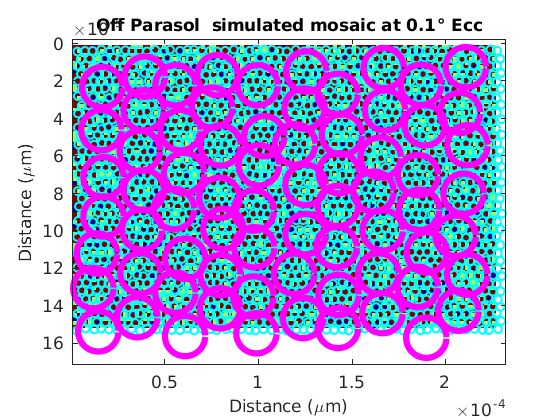

In [18]:
%% Plot the cone, bipolar and RGC mosaics

mosaicPlot(innerRetinaSU,bp,sensor,params,cellType,ecc);
set(gca,'fontsize',8)

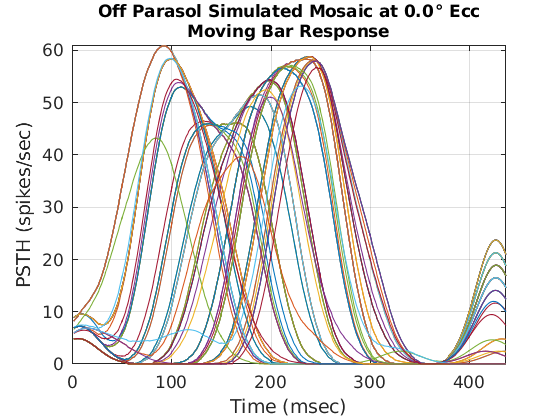

Spike Generation:
Elapsed time is 0.866098 seconds.
Elapsed time is 0.913696 seconds.
     
Spike Generation:
Elapsed time is 0.843306 seconds.
Elapsed time is 0.895280 seconds.

lastSpikeTime =

   437


In [20]:
%% Compute the inner retina response

innerRetinaSU = irCompute(innerRetinaSU, bp); 

% Get the PSTH from the object
innerRetinaSUPSTH = mosaicGet(innerRetinaSU.mosaic{1},'responsePsth');

% Plot all of the PSTHs together
figure; plot(vertcat(innerRetinaSUPSTH{:})')
title(sprintf('%s Simulated Mosaic at %1.1f\\circ Ecc\nMoving Bar Response',cellType(1:end-4),ecc));
xlabel('Time (msec)'); ylabel('PSTH (spikes/sec)');
set(gca,'fontsize',14);
lastSpikeTime=innerRetinaSU.mosaic{1}.mosaicGet('lastspiketime')
axis([0 lastSpikeTime 0 max(max(vertcat(innerRetinaSUPSTH{:})))]);
grid on;
set(gca,'fontsize',8)